## Intro to deep learning for medical imaging by [MD.ai](https://www.md.ai)

## Lesson 1. Classification of chest vs. adominal X-rays 

This is a high-level introduction into practical machine learning for medical image classification. The goal of this tutorial is to build a deep learning classifier to accurately differentiate between chest and abdominal X-rays. The model is trained using 75 images de-identified images obtained from Open-i.

MD.ai is used to dispaly the DICOM images, and to create the image-level annotations. We then use the MD.ai python client library to download the images+annotations and prepare the datasets, which are then used to train the classification model. 

- Original public github repo is based on: https://github.com/ImagingInformatics/machine-learning
- MD.ai annotator project URL: https://public.md.ai/annotator/project/PVq9raBJ
- MD.ai python client libray URL: https://github.com/mdai/mdai-client-py
- MD.ai documentation URL: https://docs.md.ai

**Intro to deep learning for medical imaging [lessons](https://github.com/mdai/ml-lessons) by MD.ai**

| # | Name  | GitHub  | <span>MD.ai</span>  | Colab |
|---|---|---|---|---|
| 1  | Classification of chest vs. adominal X-rays using TensorFlow/Keras | [Link](https://github.com/mdai/ml-lessons/blob/master/lesson1-xray-images-classification.ipynb) | [Link](https://public.md.ai/annotator/project/PVq9raBJ) | [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mdai/ml-lessons/blob/master/lesson1-xray-images-classification.ipynb) |
| 2  | Lung X-Rays Semantic Segmentation using U-Nets | [Link](https://github.com/mdai/ml-lessons/blob/master/lesson2-lung-xrays-segmentation.ipynb) | [Link](https://public.md.ai/annotator/project/aGq4k6NW) | [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mdai/ml-lessons/blob/master/lesson2-lung-xrays-segmentation.ipynb) |
| 3a | RSNA Pneumonia detection using Kaggle data format | [Link](https://github.com/mdai/ml-lessons/blob/master/lesson3-rsna-pneumonia-detection-kaggle.ipynb) | [Link](https://public.md.ai/annotator/project/LxR6zdR2) | [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mdai/ml-lessons/blob/master/lesson3-rsna-pneumonia-detection-kaggle.ipynb) |
| 3b | RSNA Pneumonia detection using the <span>MD.ai</span> python client library | [Link](https://github.com/mdai/ml-lessons/blob/master/lesson3-rsna-pneumonia-detection-mdai-client-lib.ipynb) | [Link](https://public.md.ai/annotator/project/LxR6zdR2) | [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mdai/ml-lessons/blob/master/lesson3-rsna-pneumonia-detection-mdai-client-lib.ipynb) |

*Copyright 2018-2020 MD.ai, Inc.   
Licensed under the Apache License, Version 2.0*

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mdai/ml-lessons/blob/master/lesson1-xray-images-classification.ipynb)

**Clink the badge above to launch this notebook on Google Colab.**
To use GPU, go to Runtime -> Change runtime type -> switch to Python 3, and turn on GPU.

### Import the `mdai` library

On Colab, run the block below to install the `mdai` client library into your python environment.

In [1]:
#%%bash

#pip install -q -U mdai

In [2]:
import mdai
mdai.__version__

'0.5.0'

### Create an `mdai` client

The mdai client requires an access token, which authenticates you as the user. To create a new token or select an existing token, navigate to the "Personal Access Tokens" tab on your user settings page at the specified MD.ai domain (e.g., public.md.ai).

**Important: keep your access tokens safe. Do not ever share your tokens.**

In [3]:
mdai_client = mdai.Client(domain='public.md.ai', access_token="xxx")

Successfully authenticated to public.md.ai.


### Define project

Define a project you have access to by passing in the project id. The project id can be found in the URL in the following format: `https://public.md.ai/annotator/project/{project_id}`.

For example, `project_id` would be `PVq9raBJ` for `https://public.md.ai/annotator/project/PVq9raBJ`.

Specify optional `path` as the data directory (if left blank, will default to current working directory).

In [4]:
p = mdai_client.project('PVq9raBJ', path='./lesson1-data')

Using path './lesson1-data' for data.
Preparing annotations export for project PVq9raBJ...                                                
Using cached annotations data for project PVq9raBJ.
Preparing images export for project PVq9raBJ...                                                     
Using cached images data for project PVq9raBJ.


### Set label ids

Selected label ids must be explicitly set by `Project#set_label_ids` method in order to prepare datasets.

In [5]:
p.show_label_groups()

Label Group, Id: G_BdW4M5, Name: Default group
	Labels:
	Id: L_38Y7Jl, Name: Abdomen
	Id: L_z8xEkB, Name: Chest



In [6]:
# this maps label ids to class ids as a dict obj
labels_dict = {
    'L_38Y7Jl': 0, # Abdomen 
    'L_z8xEkB': 1, # Chest  
}

print(labels_dict)
p.set_labels_dict(labels_dict)

{'L_38Y7Jl': 0, 'L_z8xEkB': 1}


### Create the *Training* and *Validation* datasets

In [7]:
p.show_datasets() 

Datasets:
Id: D_8ogmzN, Name: TRAIN
Id: D_OoJ98E, Name: VAL
Id: D_8oAvmQ, Name: TEST



In [8]:
# create training dataset 
train_dataset = p.get_dataset_by_name('TRAIN')
train_dataset.prepare() 
train_image_ids = train_dataset.get_image_ids()
print(len(train_image_ids))

# create the validation dataset 
val_dataset = p.get_dataset_by_name('VAL')
val_dataset.prepare()
val_image_ids = val_dataset.get_image_ids()
print(len(val_image_ids))

65
10


### Display a few images

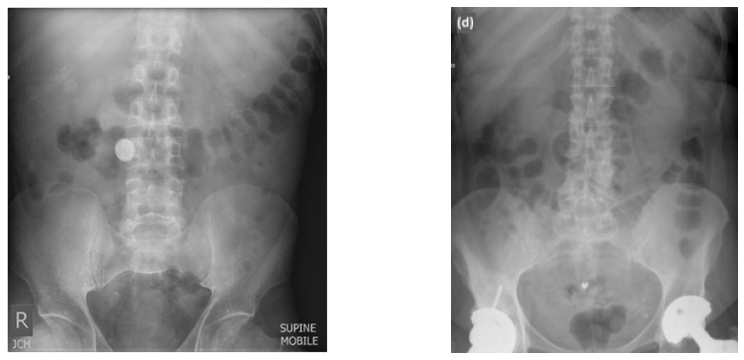

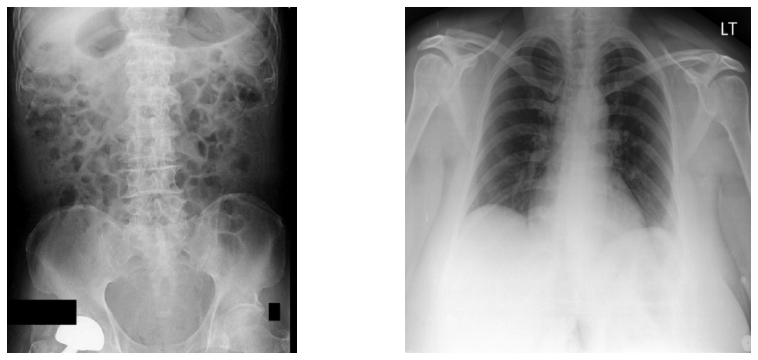

In [9]:
# visualize a few train images 
mdai.visualize.display_images(train_image_ids[:2], cols=2)
mdai.visualize.display_images(val_image_ids[:2], cols=2)

### Use tf.keras for training and validation

On Colab run the following %tensorflow_version line magic function to set tensorflow to v2.

In [10]:
#%tensorflow_version 2.x

In [2]:
import tensorflow as tf
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 

print(tf.__version__)
tf.keras.backend.clear_session()

['/device:CPU:0', '/device:XLA_CPU:0', '/device:XLA_GPU:0']
2.2.0


In [3]:
with tf.device('/device:XLA_GPU:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')

In [12]:
# Define model parameters 
img_width = 224
img_height = 224
epochs = 100

params = {
    'dim': (img_width, img_height),
    'batch_size': 5,
    'n_classes': 2,
    'n_channels': 3,
    'shuffle': True,
}

In [13]:
base_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, 
                                             input_shape=(img_width, img_height, 3))

output = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(2, activation='softmax')(output)

model = tf.keras.Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), 
              loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

In [14]:
from mdai.visualize import load_dicom_image
import numpy as np
from PIL import Image


class DataGenerator(tf.keras.utils.Sequence):
    def __init__(
        self,
        dataset,
        batch_size=32,
        dim=(32, 32),
        n_channels=1,
        n_classes=10,
        shuffle=True,
        to_RGB=True,
        rescale=False,
    ):
        """Generates data for Keras fit_generator() function.
        """

        # Initialization
        self.dim = dim
        self.batch_size = batch_size

        self.img_ids = dataset.image_ids
        self.imgs_anns_dict = dataset.imgs_anns_dict
        self.dataset = dataset

        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.to_RGB = to_RGB
        self.rescale = rescale
        self.on_epoch_end()

    def __len__(self):
        "Denotes the number of batches per epoch"
        return int(np.floor(len(self.img_ids) / self.batch_size))

    def __getitem__(self, index):
        "Generate one batch of data"

        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]

        # Find list of IDs
        img_ids_temp = [self.img_ids[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(img_ids_temp)

        return X, y

    def on_epoch_end(self):
        "Updates indexes after each epoch"
        self.indexes = np.arange(len(self.img_ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, img_ids_temp):
        "Generates data containing batch_size samples"

        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(img_ids_temp):
            image = load_dicom_image(ID, to_RGB=self.to_RGB, rescale=self.rescale)
            try:
                image = Image.fromarray(image)
            except Exception:
                print(
                    "Pil.Image can't read image. Possible 12 or 16 bit image. Try rescale=True to "
                    + "scale to 8 bit."
                )

            image = image.resize((self.dim[0], self.dim[1]))

            X[i,] = image

            ann = self.imgs_anns_dict[ID][0]
            y[i] = self.dataset.classes_dict[ann["labelId"]]["class_id"]
        return X, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

In [15]:
train_generator = DataGenerator(train_dataset, **params)
val_generator = DataGenerator(val_dataset, **params)

In [16]:
# Set callback functions to early stop training and save the best model so far
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, verbose=2, min_delta=1e-3),
    tf.keras.callbacks.ModelCheckpoint(filepath='./lesson1-model/model.h5', monitor='val_loss', 
                                       save_best_only=True, verbose=2)
]

history = model.fit(
    train_generator,
    epochs=epochs,
    verbose=1,
    callbacks=callbacks,
    validation_data=val_generator,
)

Epoch 1/100
13/13 [==============================] - ETA: 0s - loss: 0.3106 - accuracy: 0.8769
Epoch 00001: val_loss improved from inf to 3.68645, saving model to ./lesson1-model/model.h5
13/13 [==============================] - 2s 182ms/step - loss: 0.3106 - accuracy: 0.8769 - val_loss: 3.6864 - val_accuracy: 0.5000
Epoch 2/100
13/13 [==============================] - ETA: 0s - loss: 0.2813 - accuracy: 0.9231
Epoch 00002: val_loss improved from 3.68645 to 3.38437, saving model to ./lesson1-model/model.h5
13/13 [==============================] - 2s 149ms/step - loss: 0.2813 - accuracy: 0.9231 - val_loss: 3.3844 - val_accuracy: 0.5000
Epoch 3/100
13/13 [==============================] - ETA: 0s - loss: 0.0190 - accuracy: 1.0000
Epoch 00003: val_loss improved from 3.38437 to 2.40429, saving model to ./lesson1-model/model.h5
13/13 [==============================] - 2s 150ms/step - loss: 0.0190 - accuracy: 1.0000 - val_loss: 2.4043 - val_accuracy: 0.5000
Epoch 4/100
13/13 [================

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


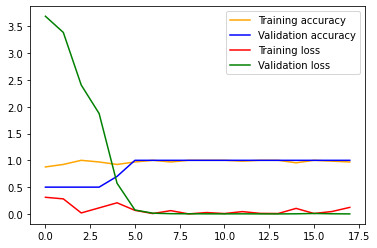

In [17]:
import matplotlib.pyplot as plt

print(history.history.keys())

plt.figure()
plt.plot(history.history['accuracy'], 'orange', label='Training accuracy')
plt.plot(history.history['val_accuracy'], 'blue', label='Validation accuracy')
plt.plot(history.history['loss'], 'red', label='Training loss')
plt.plot(history.history['val_loss'], 'green', label='Validation loss')
plt.legend()
plt.show()

### Create the *Test* dataset

For each test image, we will also create Grad-CAM and SmoothGrad explanatory visualizations, using the [tf-explain](https://github.com/sicara/tf-explain) library.

On Colab run the following %tensorflow_version line magic function to set tensorflow to v2.

In [18]:
#%tensorflow_version 2.x

In [19]:
#%%bash

#pip install -q -U tf-explain

In [20]:
import tensorflow as tf

print(tf.__version__)
tf.keras.backend.clear_session()

2.2.0


In [21]:
model = tf.keras.models.load_model('./lesson1-model/model.h5')

In [22]:
test_dataset = p.get_dataset_by_name('TEST')
test_dataset.prepare()

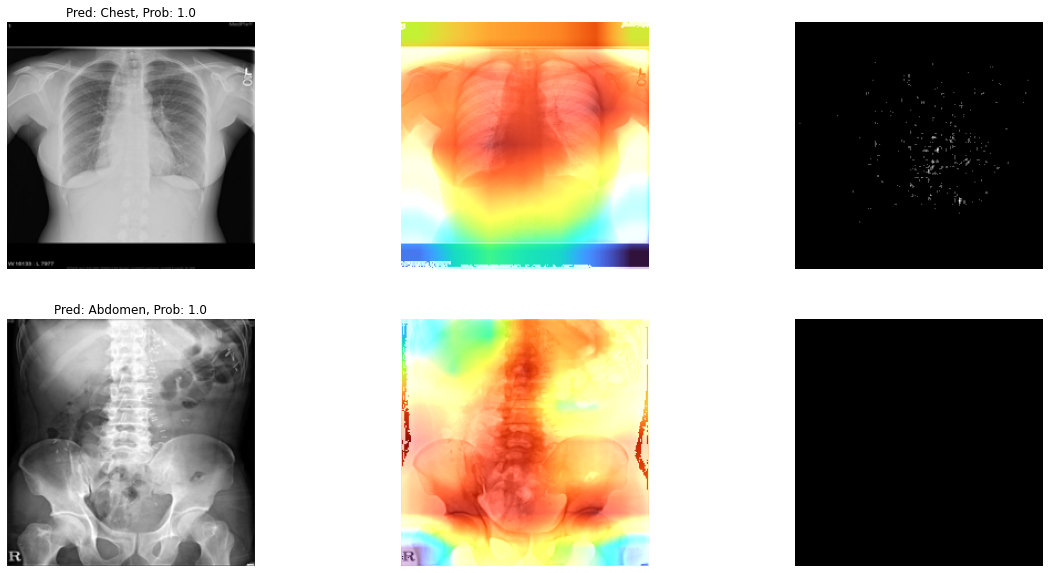

In [23]:
import numpy as np
from PIL import Image
from tf_explain.core.grad_cam import GradCAM
from tf_explain.core.smoothgrad import SmoothGrad
import cv2
import matplotlib.pyplot as plt

img_width = 224
img_height = 224

plt.figure(figsize=(20, 10))

for i, image_id in enumerate(test_dataset.image_ids): 
    
    image = mdai.visualize.load_dicom_image(image_id, to_RGB=True)
    image = Image.fromarray(image)
    image = image.resize((img_width, img_height))
    
    X = np.empty((1, img_width, img_height, 3))
    X[0,:] = image
    y_prob = model.predict(X)
    y_classes = y_prob.argmax(axis=-1)
    
    pred_class = test_dataset.class_id_to_class_text(y_classes[0])
    pred_prob = y_prob[0][y_classes[0]]
    title = f'Pred: {pred_class}, Prob: {pred_prob:.3}'
    
    plt.subplot(len(test_dataset.image_ids), 3, i*3+1)
    plt.title(title)
    plt.imshow(image)
    plt.axis('off')
    
    explainer = GradCAM()
    output = explainer.explain(
        validation_data=(X, None),
        model=model,
        layer_name="conv_pw_13",
        class_index=y_classes[0],
        colormap=cv2.COLORMAP_TURBO,
    )
    
    plt.subplot(len(test_dataset.image_ids), 3, i*3+2)
    plt.imshow(output)
    plt.axis('off')
    
    explainer = SmoothGrad()
    output = explainer.explain(
        validation_data=(X, None),
        model=model,
        class_index=y_classes[0],
    )
    
    plt.subplot(len(test_dataset.image_ids), 3, i*3+3)
    plt.imshow(output, cmap='gray')
    plt.axis('off')
    
plt.show()